In [1]:
library(Matrix)
library(chromVAR)
library(SummarizedExperiment)
library(BSgenome.Hsapiens.UCSC.hg19)
library(motifmatchr)
library(MotifDb)
library(universalmotif)
library('TFBSTools')


Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, r

In [4]:
atac.counts <- read.table('/home/xionglei/data/joint_ATAC_RNA/scCAT_seq/recomb/scCAT_seq/embryo/embryo_ATAC.xls', header = T, row.names = 1, stringsAsFactors = F)
  peak.bed <- strsplit(rownames(atac.counts), split = "_")
peak.bed <- t(as.data.frame(peak.bed))
  colnames(peak.bed) <- c("chr","start","end")
peak.bed=as.data.frame(peak.bed)
peak.gr <- makeGRangesFromDataFrame(peak.bed, keep.extra.columns = T)
  names(peak.gr) <- rownames(atac.counts)
  peak.gr <- peak.gr[match(rownames(atac.counts),names(peak.gr))]
  atac.chromVAR <- SummarizedExperiment(assays = list(counts = as.matrix(atac.counts)),
                                rowRanges = peak.gr)

In [ ]:
matrices.TF <- query(MotifDb, 'hsapiens')
matrices.TF_v2 <- convert_motifs(matrices.TF, "TFBSTools-PFMatrix")
pfm.list <- do.call(PFMatrixList, matrices.TF_v2)

In [6]:
atac.chromVAR <- addGCBias(atac.chromVAR, genome = BSgenome.Hsapiens.UCSC.hg19)
atac.chromVAR.filter <- filterPeaks(atac.chromVAR, non_overlapping = F)

In [7]:
motif_ix_L <- matchMotifs(pfm.list, 
                          atac.chromVAR.filter, 
                          genome = BSgenome.Hsapiens.UCSC.hg19)

dev_L <- computeDeviations(object = atac.chromVAR.filter, 
                           annotations = motif_ix_L)
saveRDS(dev_L,'scCAT/results/Embryo_TF_Deviation.RDS')

In [ ]:
# shell
Rscript $script/Normalize_GeneExp.R ~/data/joint_ATAC_RNA/scCAT_seq/recomb/scCAT_seq/embryo/embryo_RNA.xls ./embryo_RNA.RDS

In [19]:
library(Seurat)
library(chromVAR)
library(GenomicRanges)
library(SummarizedExperiment)
library(BSgenome.Hsapiens.UCSC.hg19)
library(motifmatchr)
library(MotifDb)
library(universalmotif)
library(ggplot2)
library(pheatmap)
library(viridis)
library(ggrepel)
library(gridExtra)

Loading required package: viridisLite

Attaching package: ‘gridExtra’

The following object is masked from ‘package:Biobase’:

    combine

The following object is masked from ‘package:BiocGenerics’:

    combine



In [20]:
### loading data
#atac.dev.motifDB <- readRDS("data/scCAT/Embryo_TF_Deviation.RDS")
atac.dev.motifDB <- dev_L
rownames(atac.dev.motifDB) <- rowData(atac.dev.motifDB)$name
atac.dev.motifDB <- atac.dev.motifDB[!is.na(rownames(atac.dev.motifDB)),]
motif.list <- unique(rownames(atac.dev.motifDB))
motif.list.ix <- sapply(motif.list, function(motif) which(rownames(atac.dev.motifDB) == motif)[1])
atac.dev.motifDB <- atac.dev.motifDB[motif.list.ix,]
TF.variability <- computeVariability(atac.dev.motifDB)
variability.atac.counts.filter <- TF.variability

In [21]:
n = 100
tf.lable <- c("PITX2","HOXD8","MEF2B","TBX2","GRHL1","POU5F1","GATA5","HNF1A","YY1","ONECUT1","KLF1","OTX2","NANOG","GSC","Sox4")

### defined the function.
plotTFvariation <- function(variability.atac.counts.filter,n = 20,tf.lable){
  res_df <- cbind(variability.atac.counts.filter, 
                  rank = rank(-1 * variability.atac.counts.filter$variability, 
                              ties.method = "random"), 
                  annotation = variability.atac.counts.filter$name)
  top_df <- res_df[res_df$name %in% tf.lable, ]
  
  p <- ggplot(res_df, aes_string(x = "rank", 
                      y = "variability", 
                      min = "bootstrap_lower_bound", 
                      max = "bootstrap_upper_bound", 
                      label = "annotation")) + 
          geom_errorbar(colour = "grey") + 
          geom_point(colour = "purple",size = 1) + 
          xlab("Sorted TFs") + ylab("Variability") + 
          theme_bw() + 
          scale_y_continuous(expand= c(0, 0),
                             limits = c(0, max(res_df$bootstrap_upper_bound, na.rm = TRUE) * 1.05)) +
          geom_text_repel(data = top_df, size = 3, col = "Black") # require ggrepel package
  return(p)
}


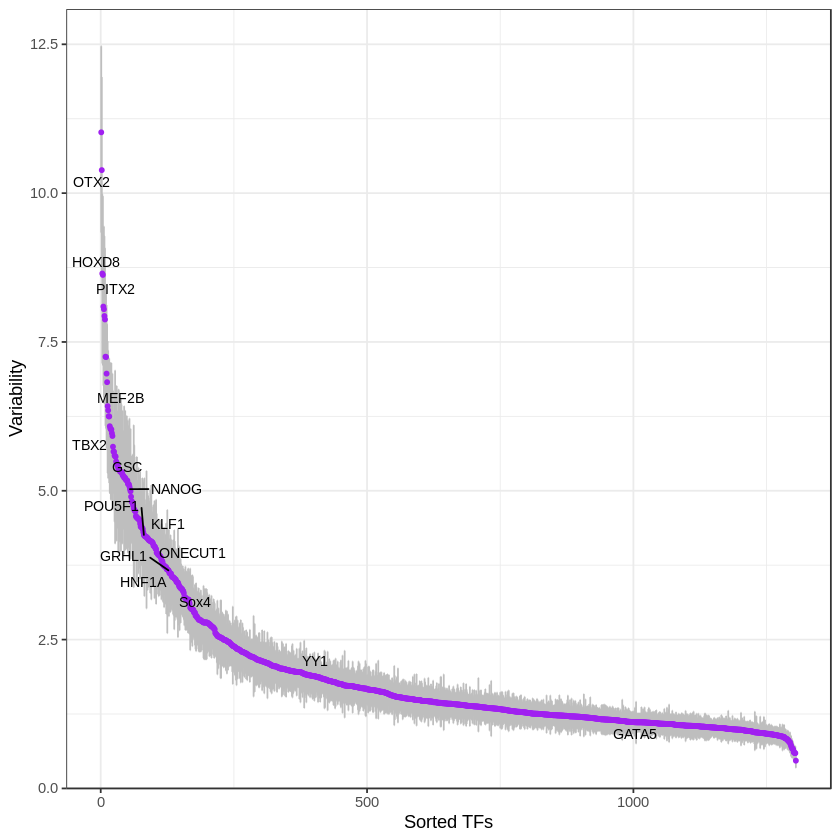

In [22]:
par(mfrow=c(1,3))

plotTFvariation(TF.variability,50,tf.lable)

$POU5F1


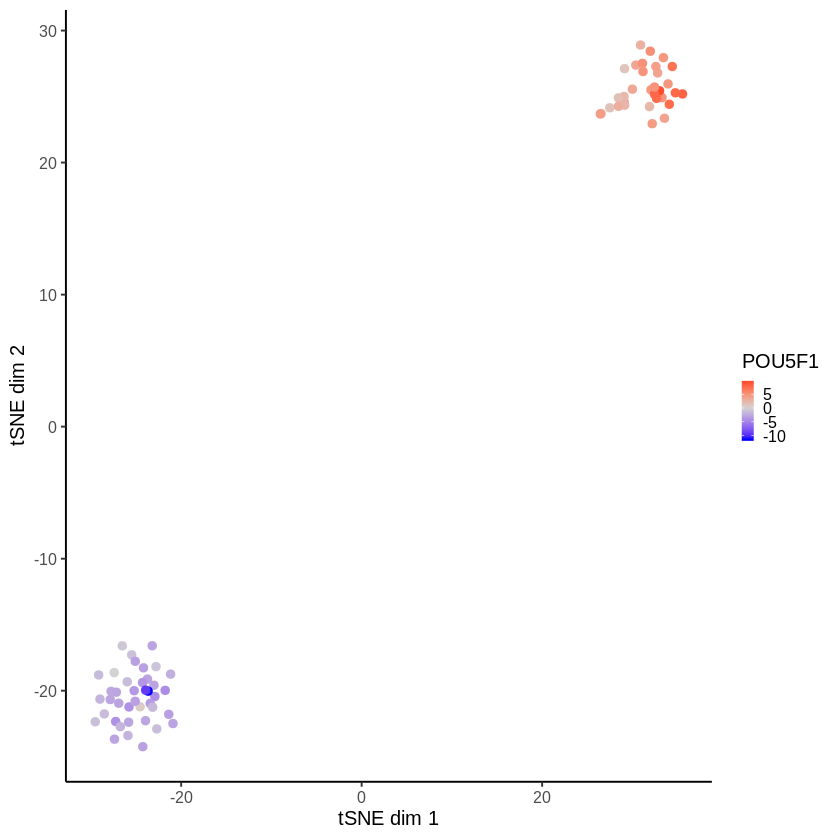

In [24]:
# Plot TSNE results
set.seed(1)
tsne_results <- deviationsTsne(atac.dev.motifDB, threshold = 1.2, perplexity = 10, shiny = FALSE)

#plotDeviationsTsne(atac.dev.motifDB, tsne_results,sample_column = "stage", shiny = FALSE)

plotDeviationsTsne(atac.dev.motifDB, tsne_results, annotation = "POU5F1", shiny = FALSE)

In [25]:
# loading Normalized RNA data by seurat
rna.seurat <- readRDS("scCAT/results/embryo_RNA.RDS") 

In [29]:
atac.dev.motifDB.copy <- atac.dev.motifDB

In [30]:
colData(atac.dev.motifDB)$group <- "group1"
colData(atac.dev.motifDB)$group[grep("scCAT_Blastocyst",colnames(atac.dev.motifDB))] <- "group2"
colData(atac.dev.motifDB)$group[grep("scCAT_Blastocyst_504|scCAT_Blastocyst_522|scCAT_Blastocyst_539",colnames(atac.dev.motifDB))] <- "group1"

In [48]:
plot_deviation_heatmap <- function(genelist) {
  tf <- genelist
  tf <- tf[tf %in% rownames(atac.dev.motifDB)]
  dat <- assays(atac.dev.motifDB)$deviations[match(tf,rownames(atac.dev.motifDB)),]
  dat <- dat[,colnames(dat)[c(grep("group1",colData(atac.dev.motifDB)$group),
                              grep("group2",colData(atac.dev.motifDB)$group))]]
  dat <- apply(dat, 1, function(tf) {
    tf.box <- boxplot(tf)
    out <- names(tf.box$out)
    tf[out] <- ifelse(tf[out] > 0, tf.box$stats[5,],tf.box$stats[1,])
    return(tf)
  })  
  label = data.frame(group = c(rep("group1",32),rep("group2",40)),
                     row.names = colnames(t(dat)))
  pheatmap(t(dat),
          scale = "row",
          cluster_cols = F,
          cluster_rows = F,
         show_rownames = T, 
         show_colnames = F,
         clustering_method = "ward.D2",
         fontsize_row = 5,
         color = viridis(100),
         border_color = NA,
         annotation_col = label)
}


In [ ]:
# provide TF list, here is an example list

genelist <- c("NANOG","POU5F1","POU2F1","POU3F1","POU3F2","POU3F3","KLF4","KLF7","KLF14","KLF16","SOX2","SOX5","SOX6","SOX9","MEF2A","MEF2B","MEF2C","MEF2D","OTX1","OTX2","TBX1","TBX3","TBX4","TBX20","HOXD4","HOXD8","HOXD9","HOXD11","GATA2","GATA3","GATA4","GATA6","GRHL1","GRHL2") # An example


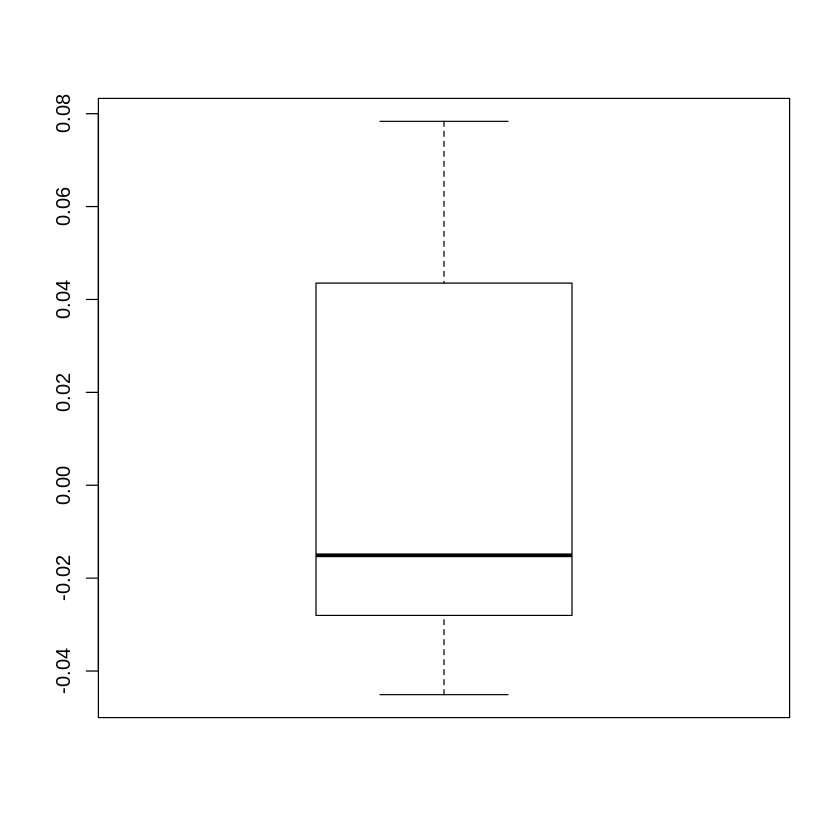

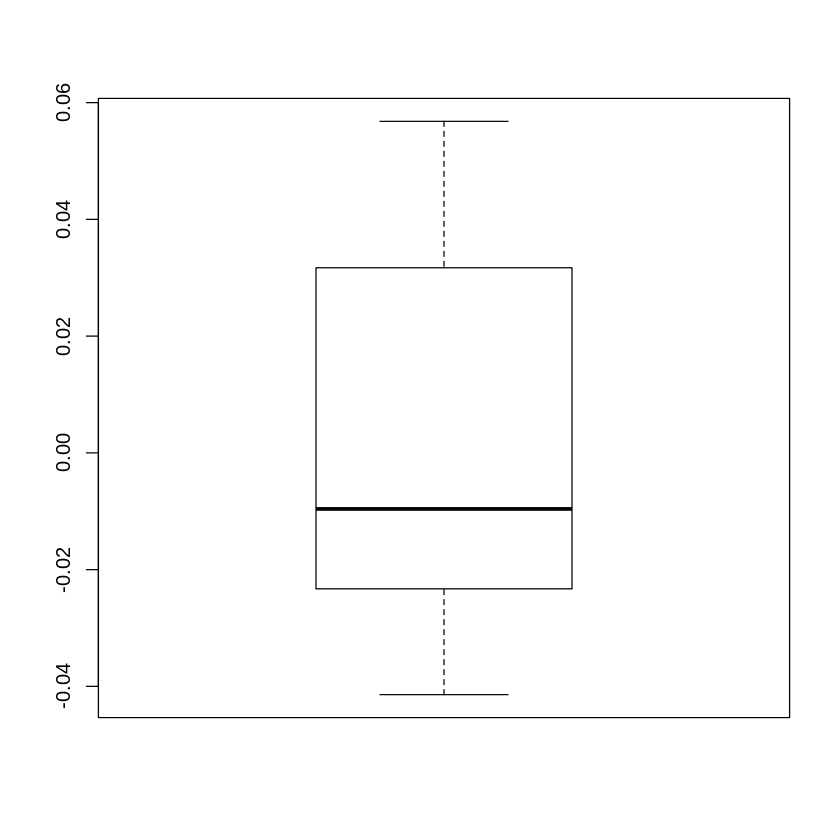

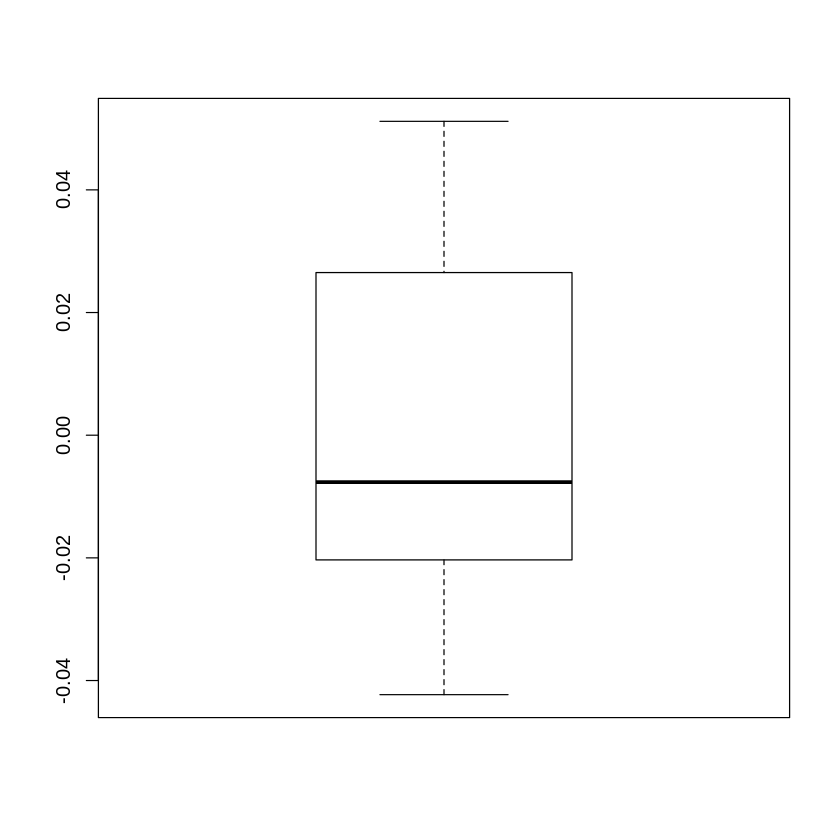

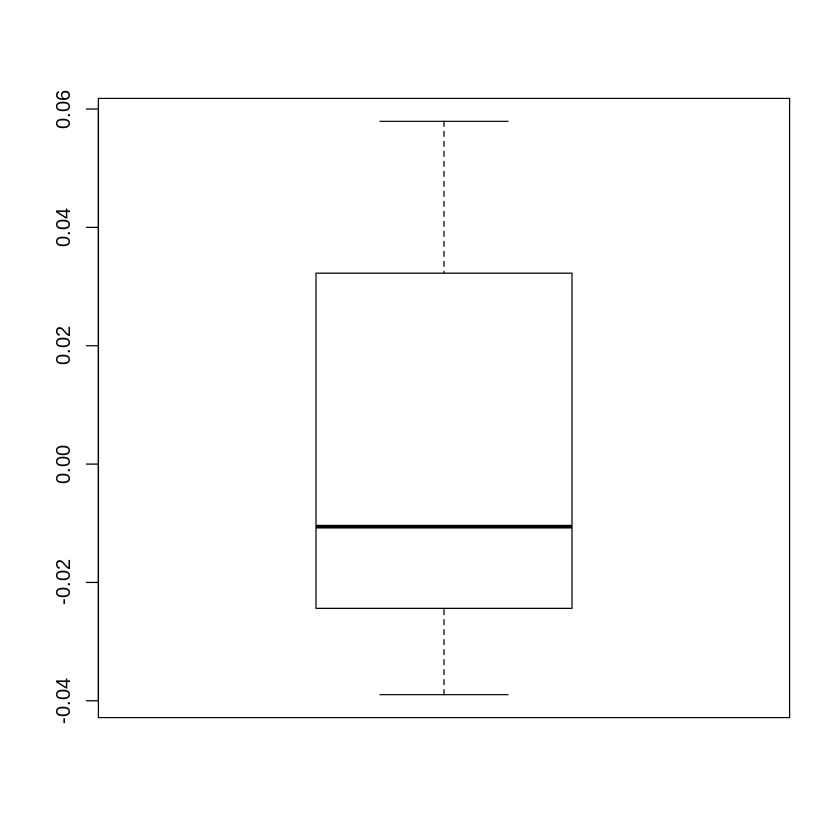

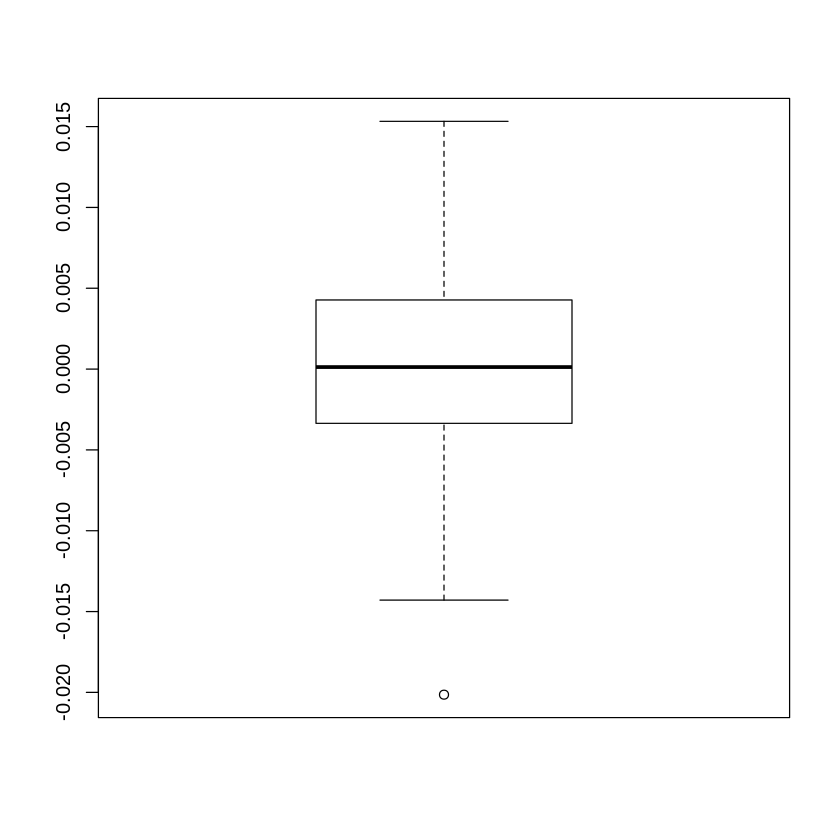

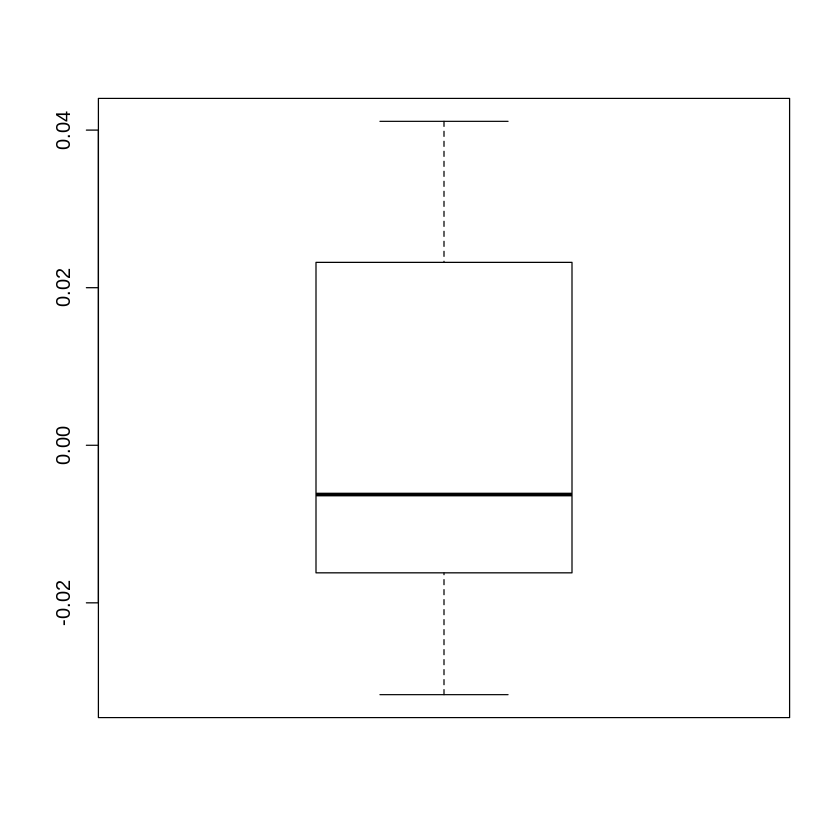

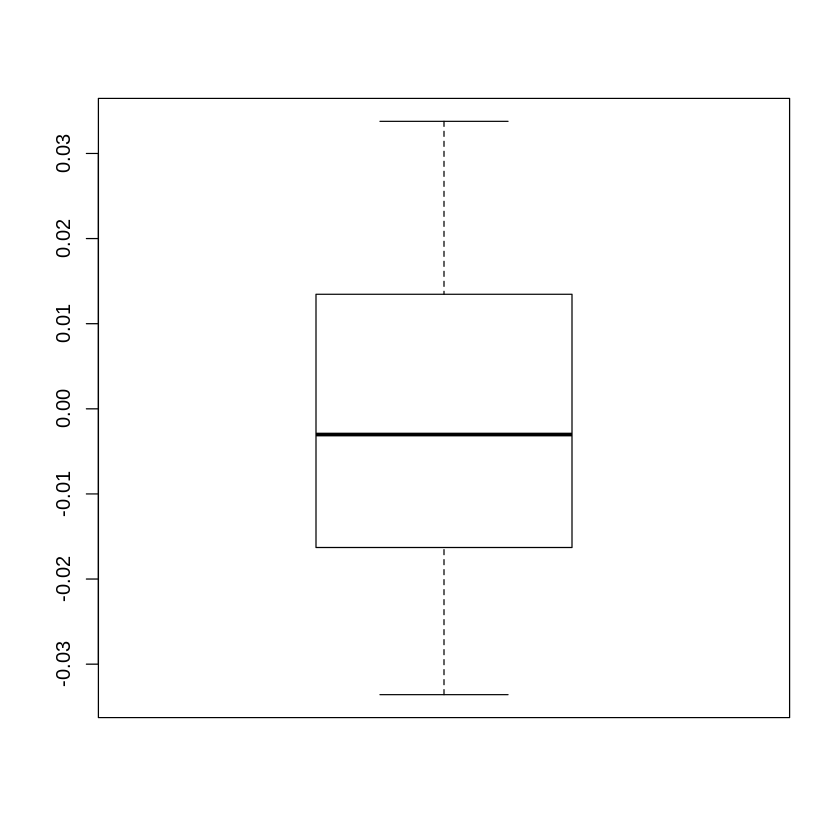

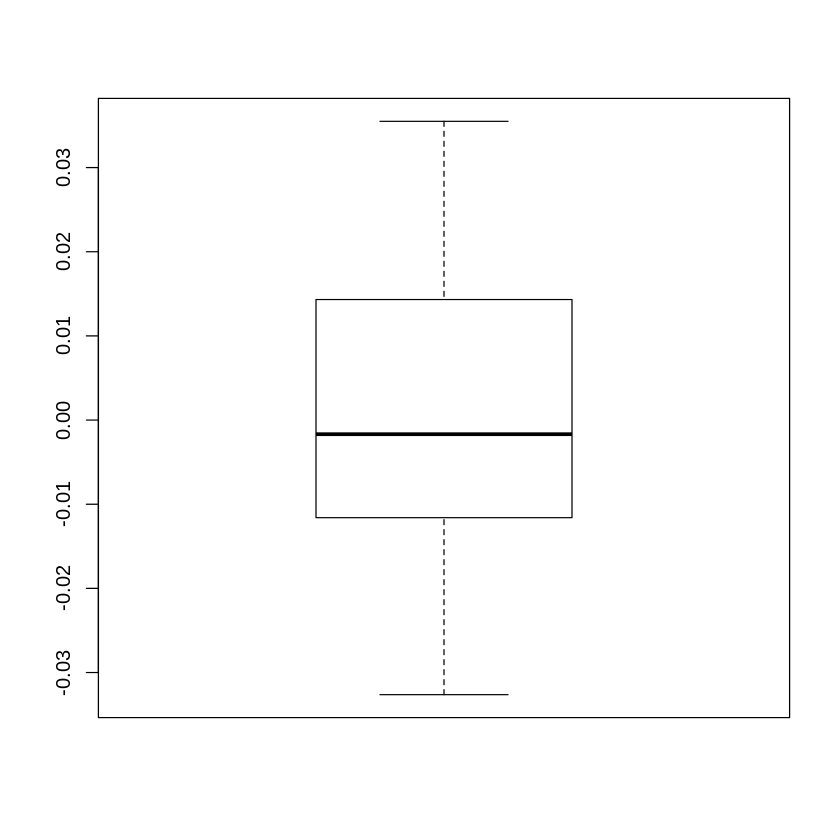

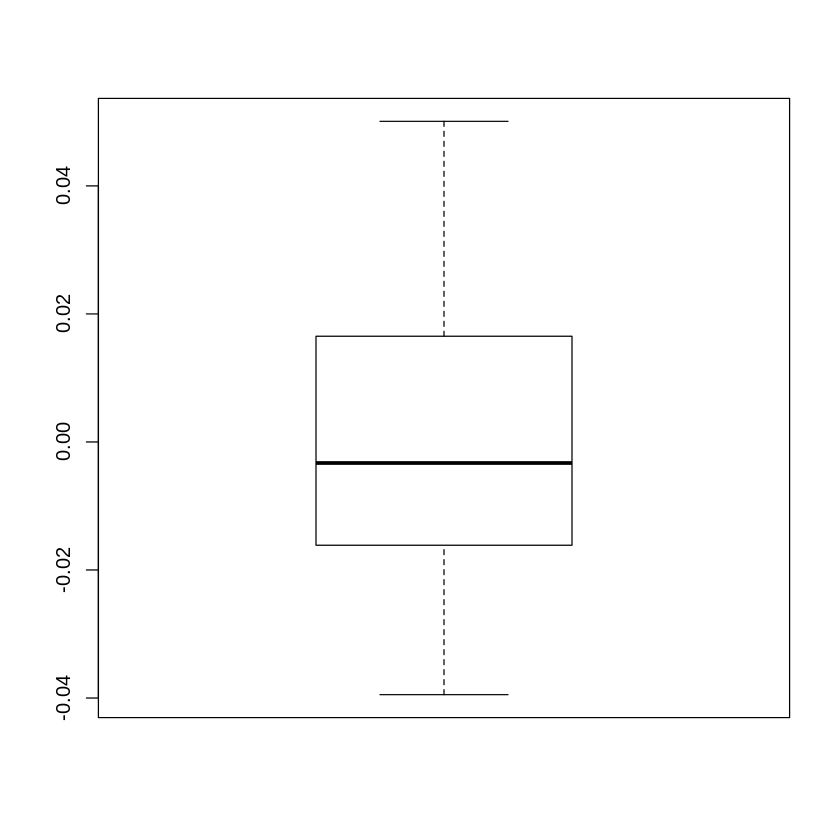

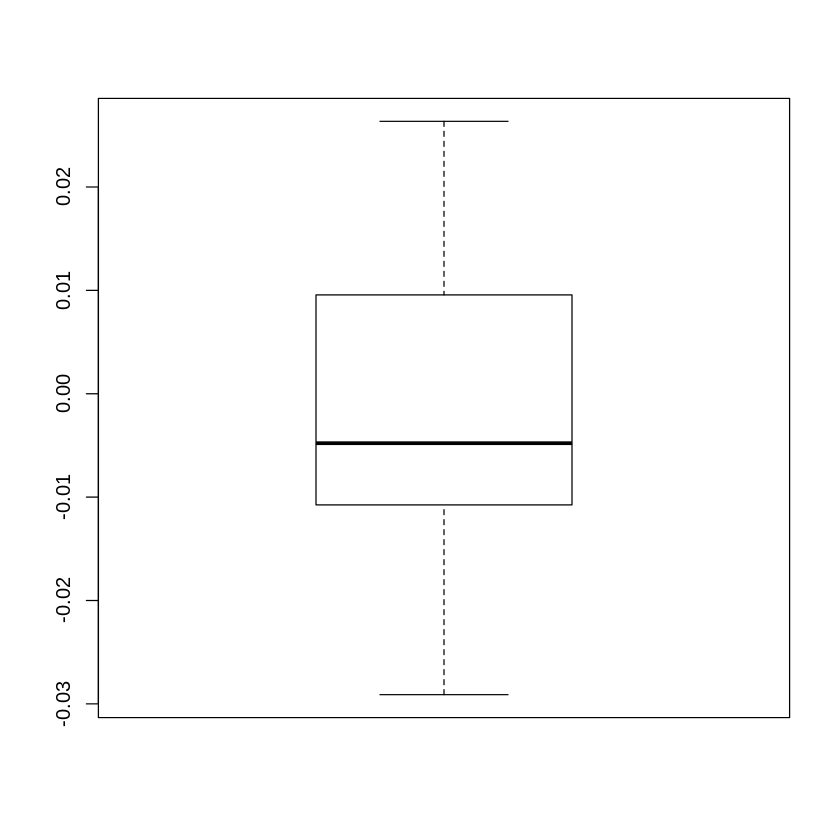

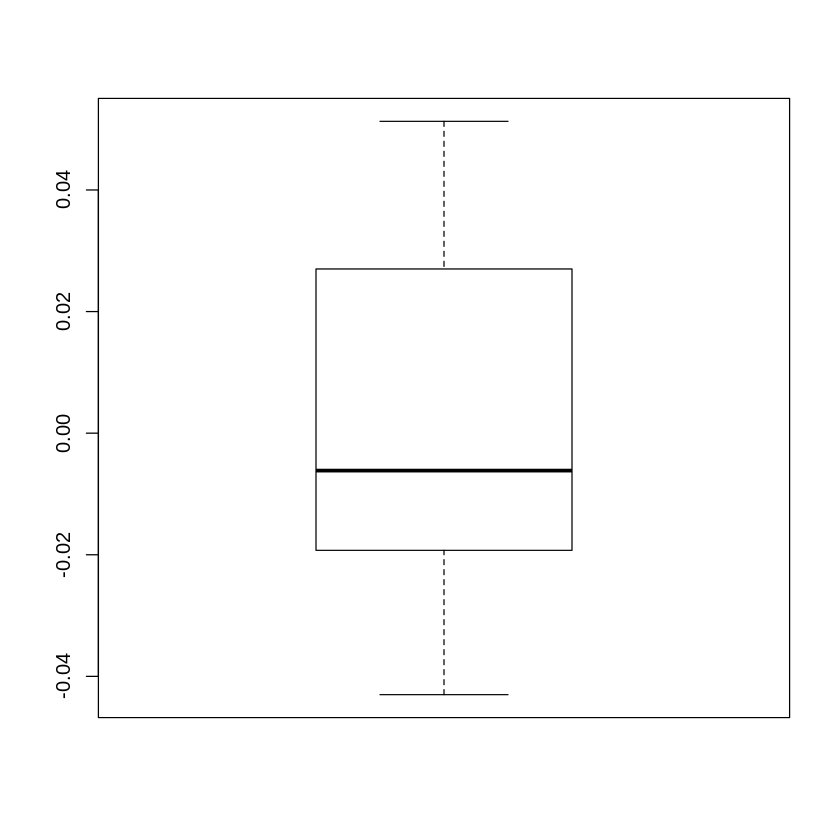

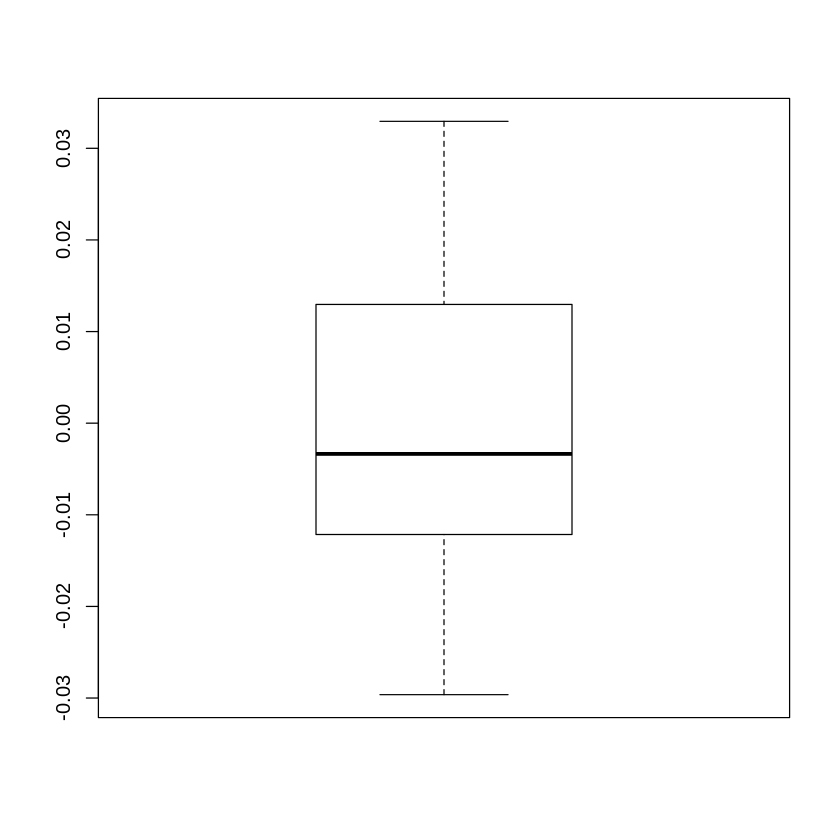

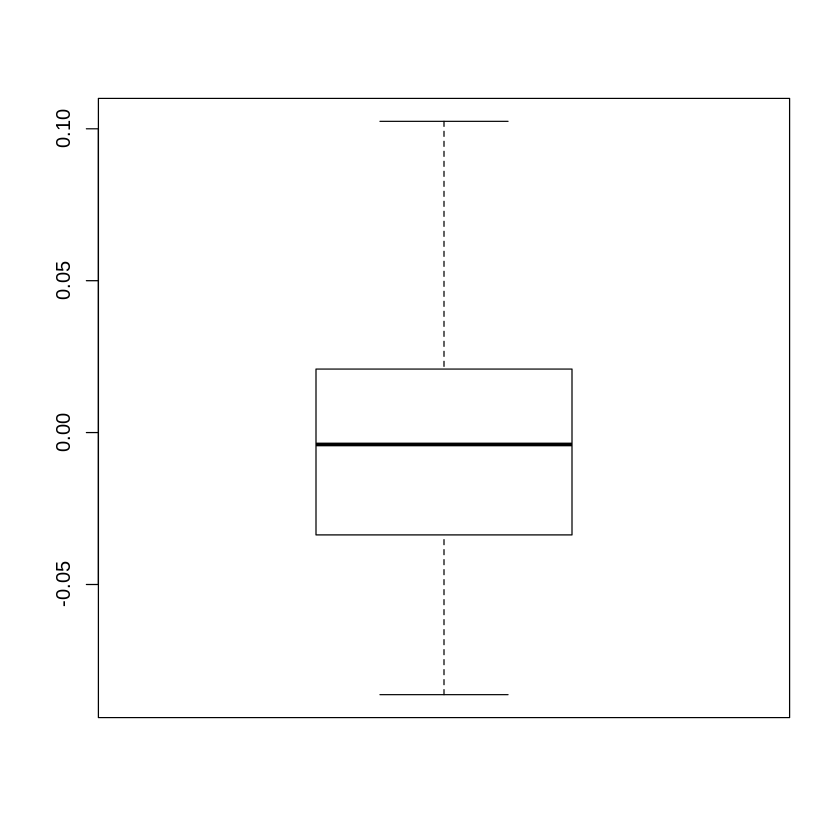

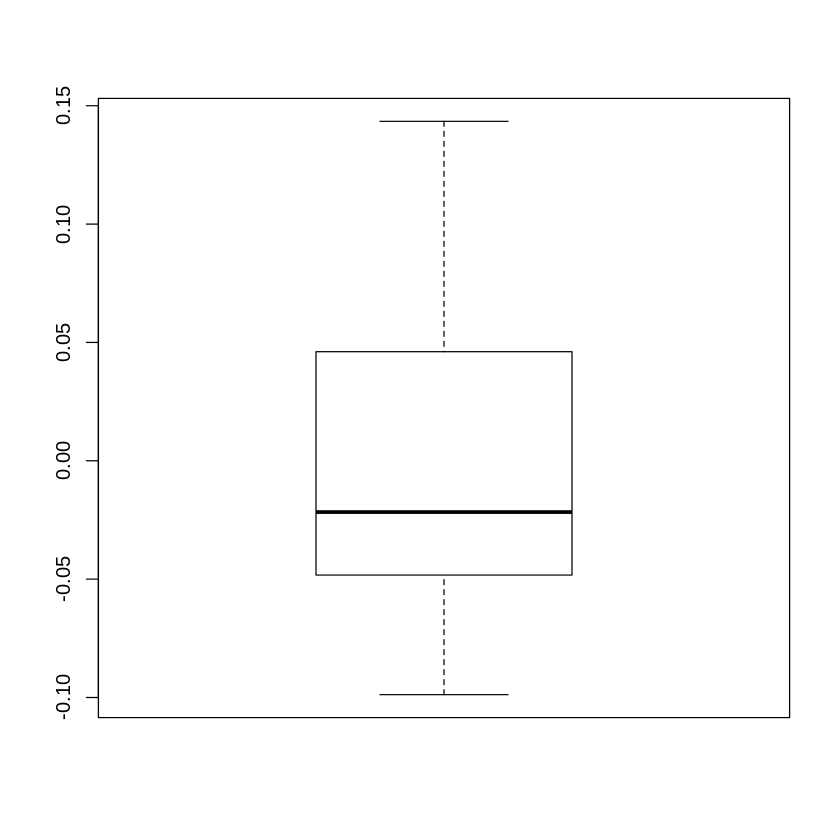

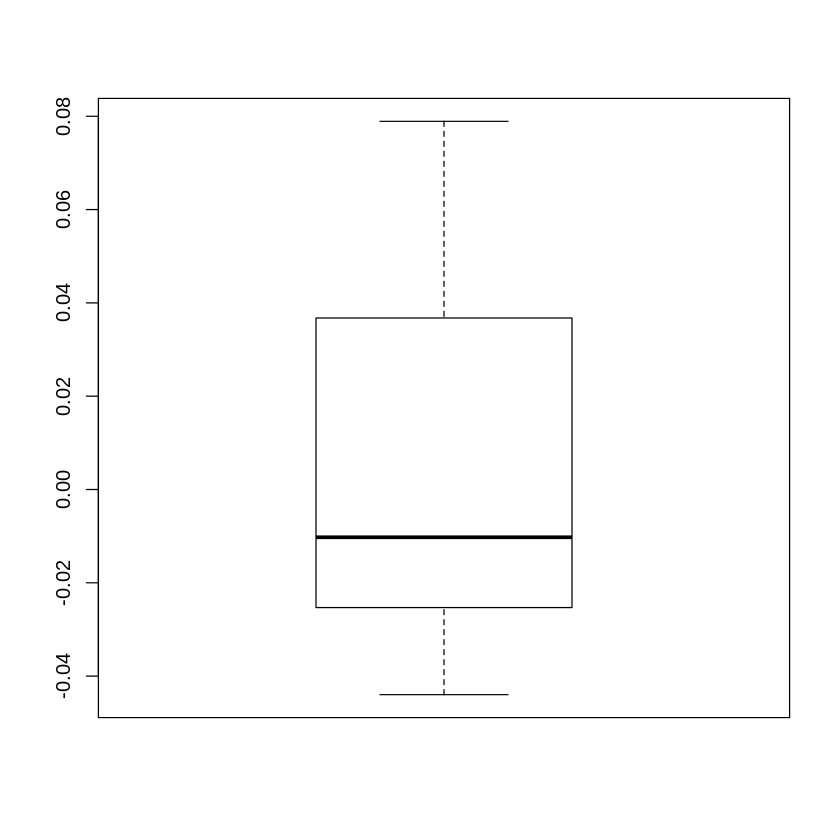

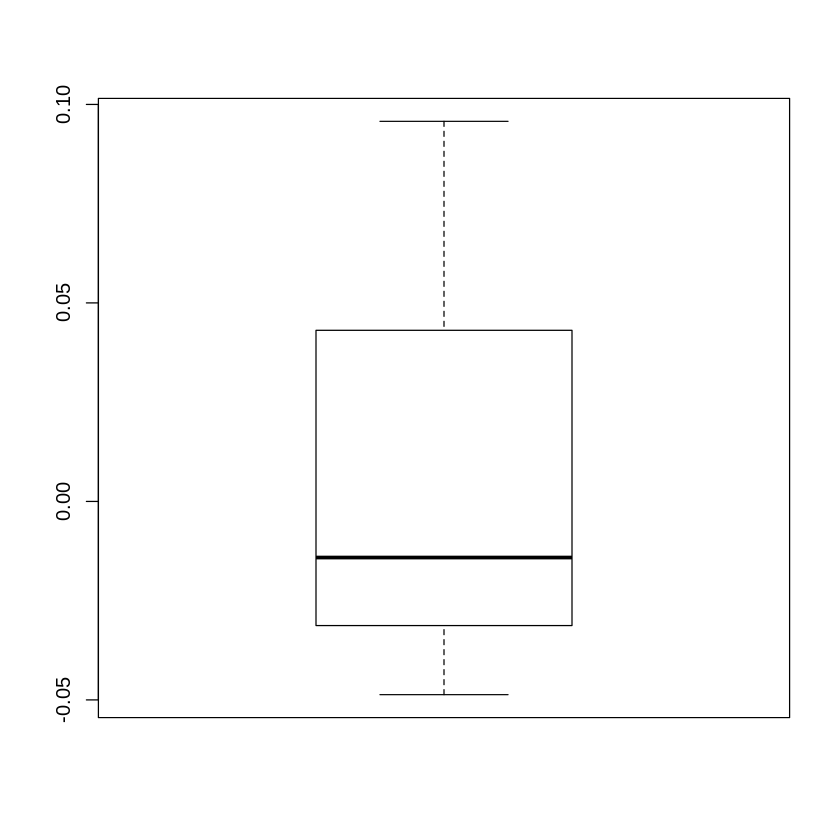

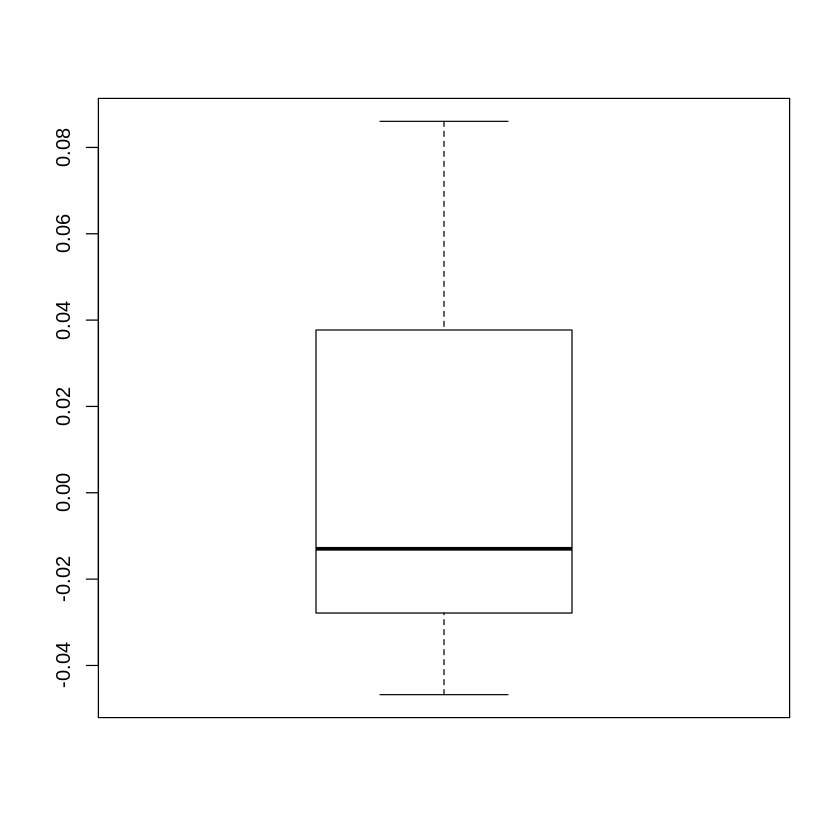

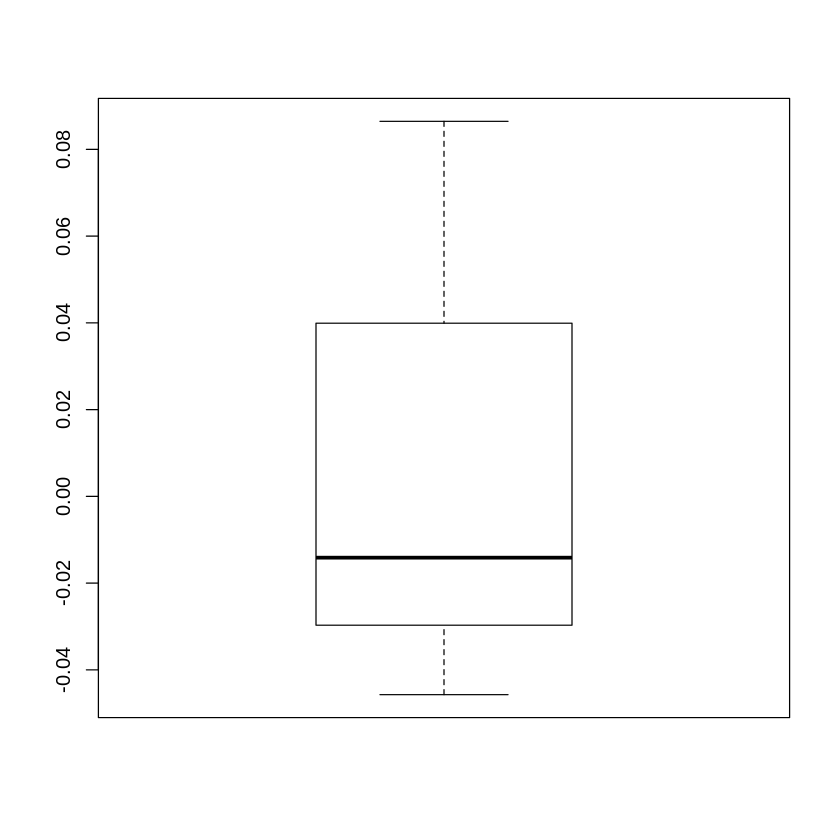

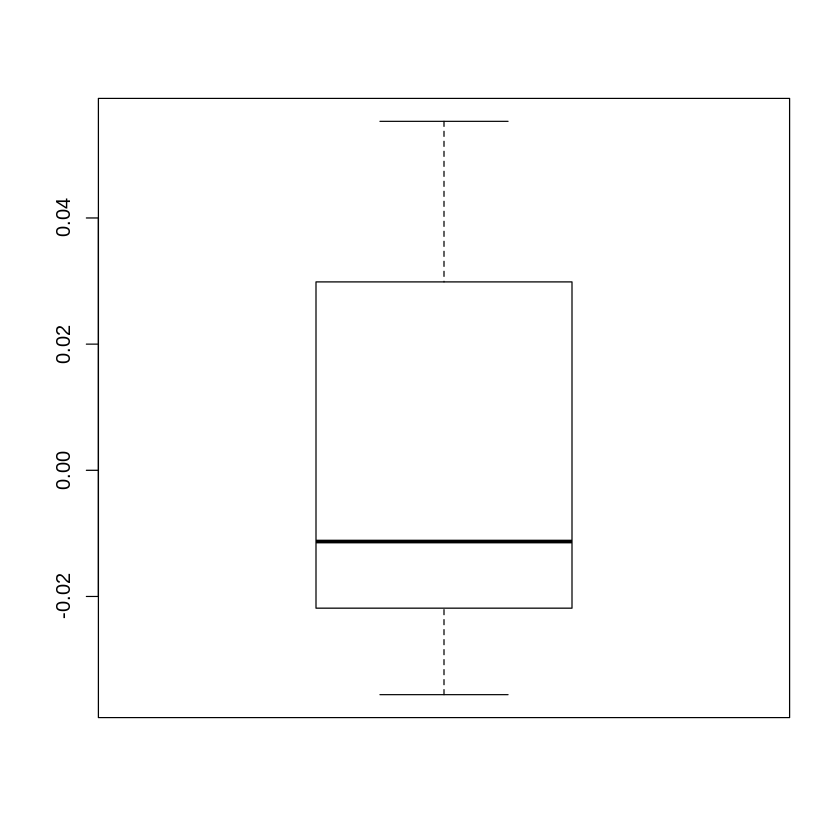

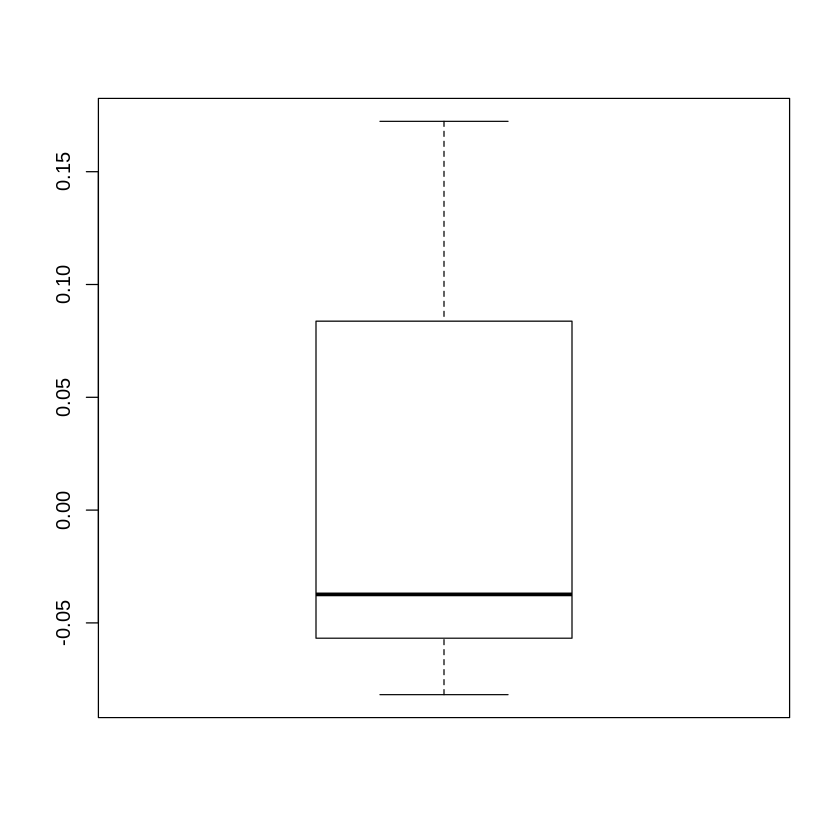

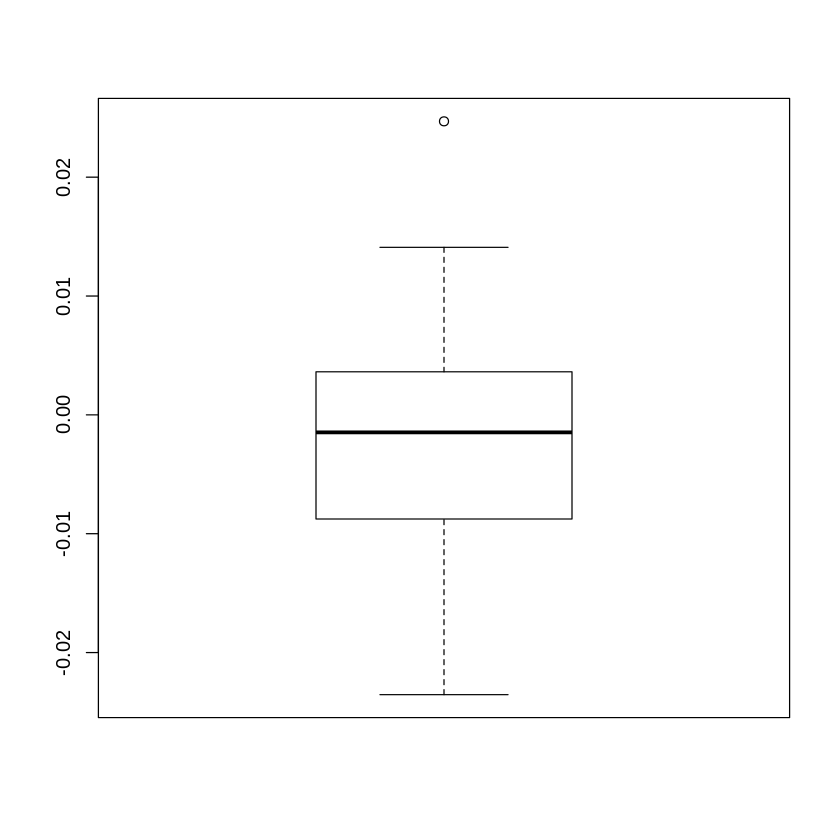

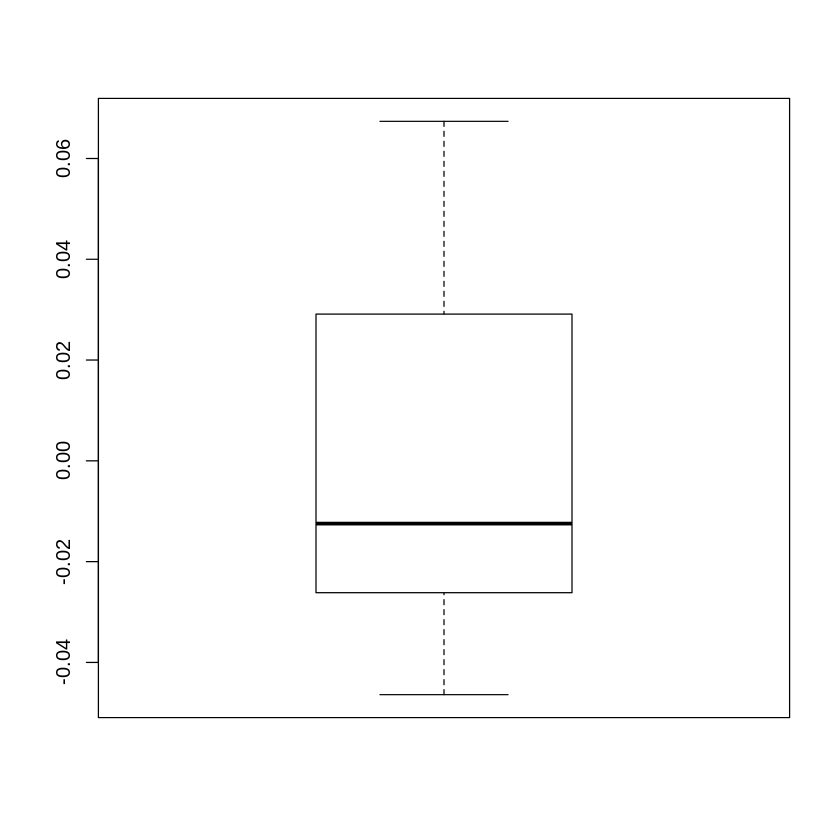

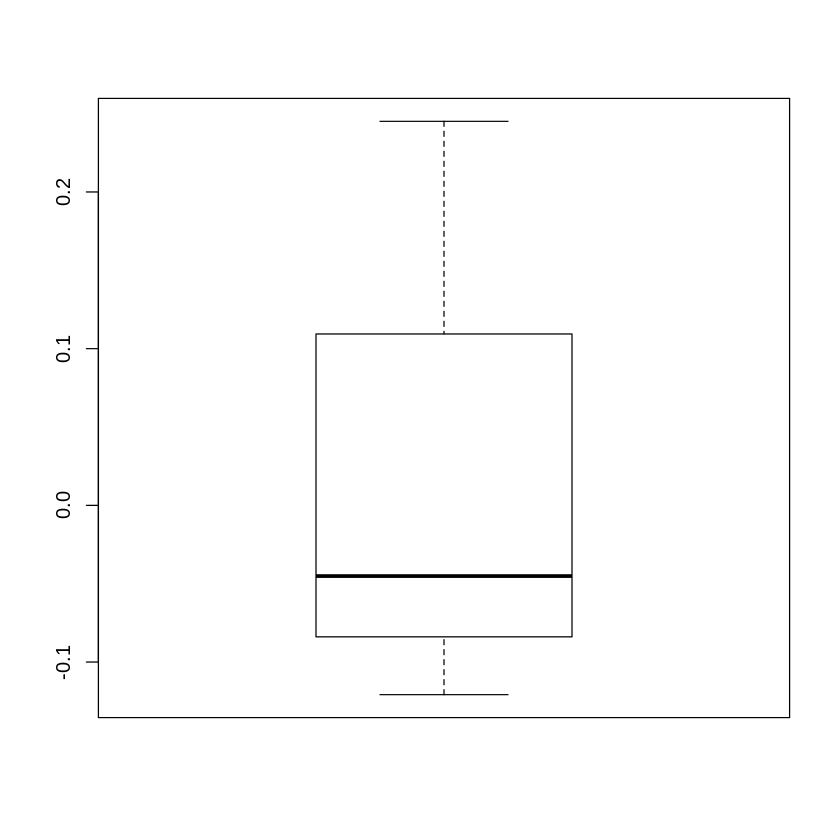

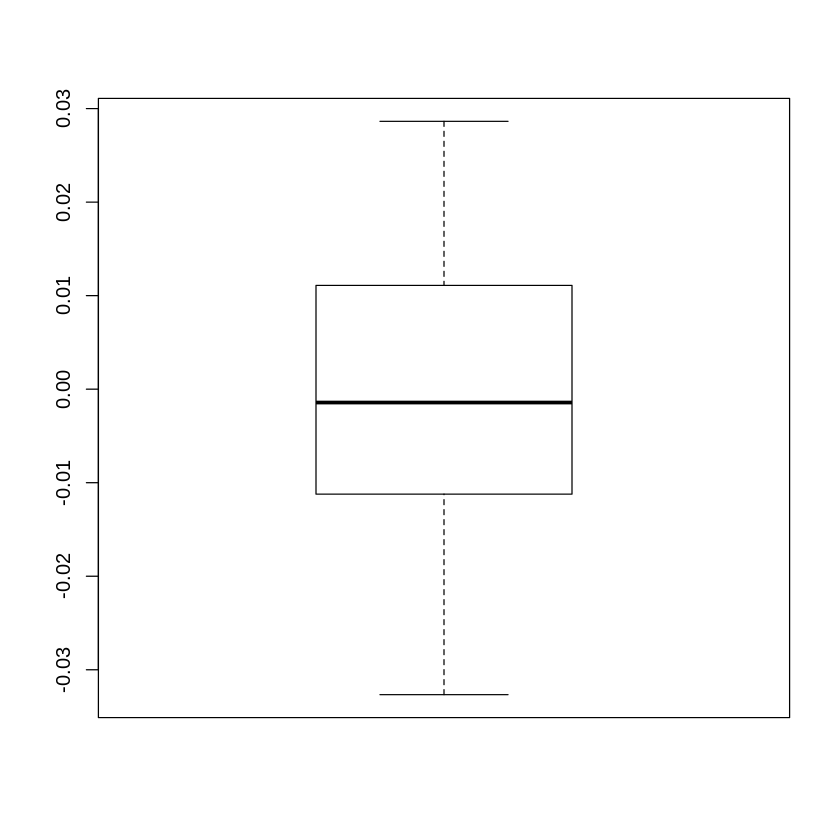

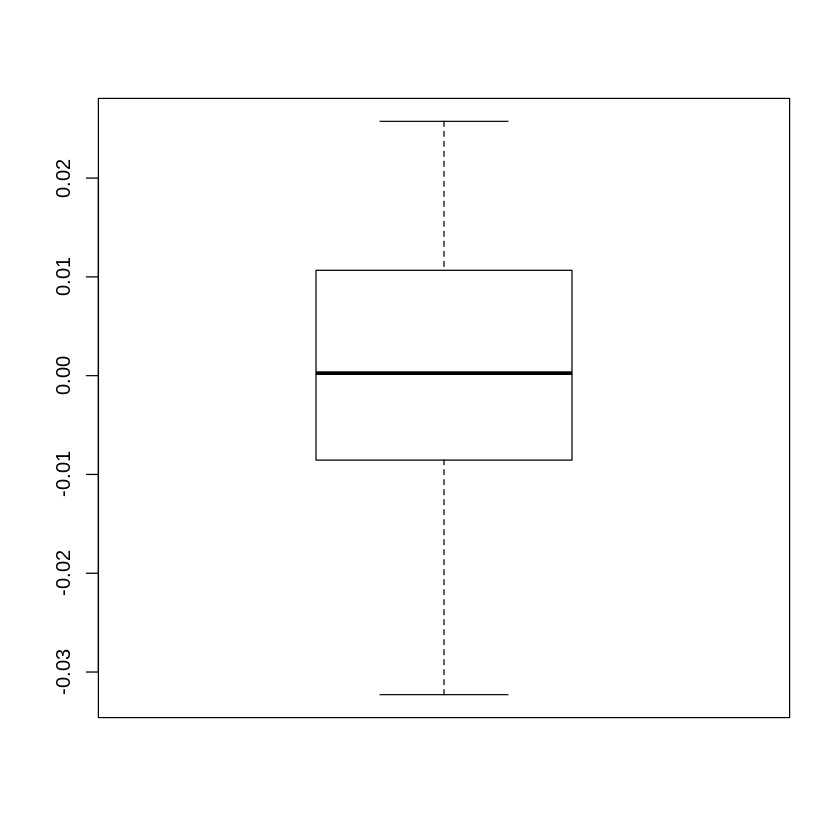

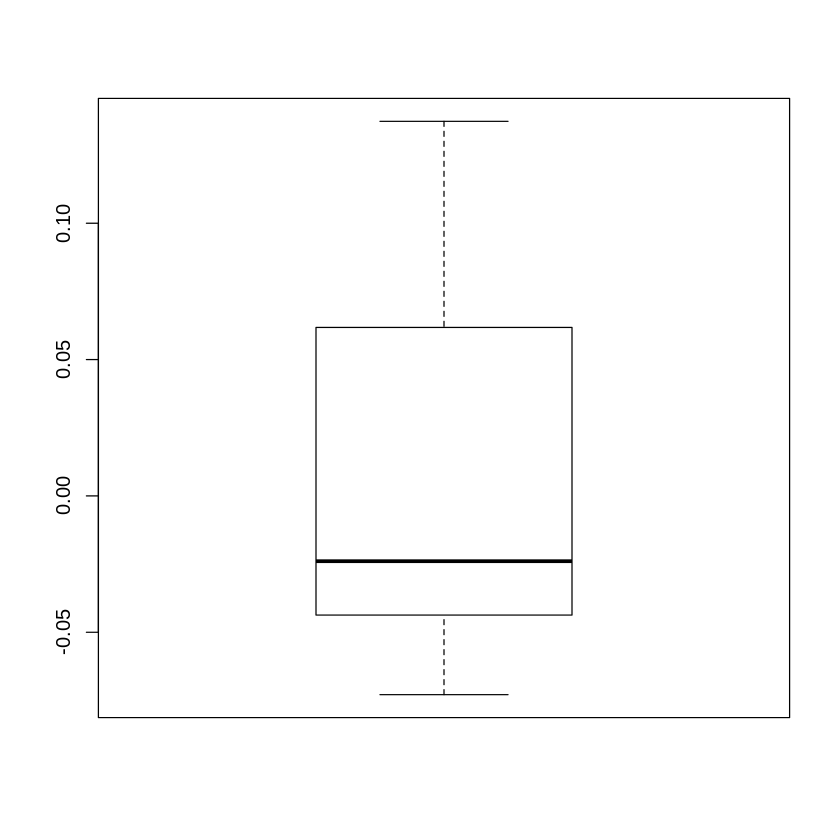

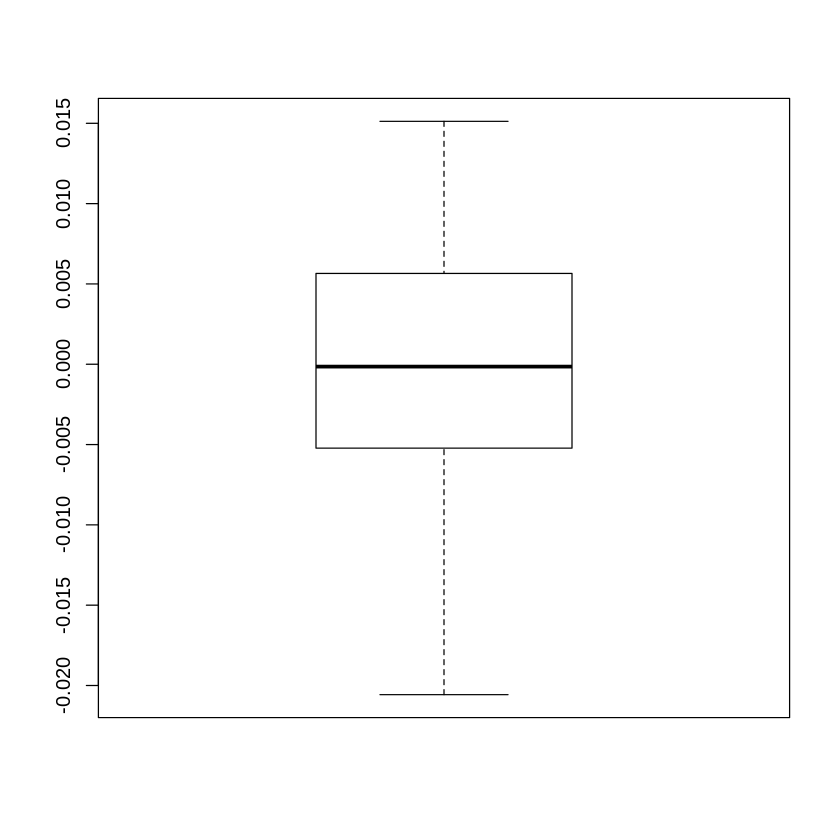

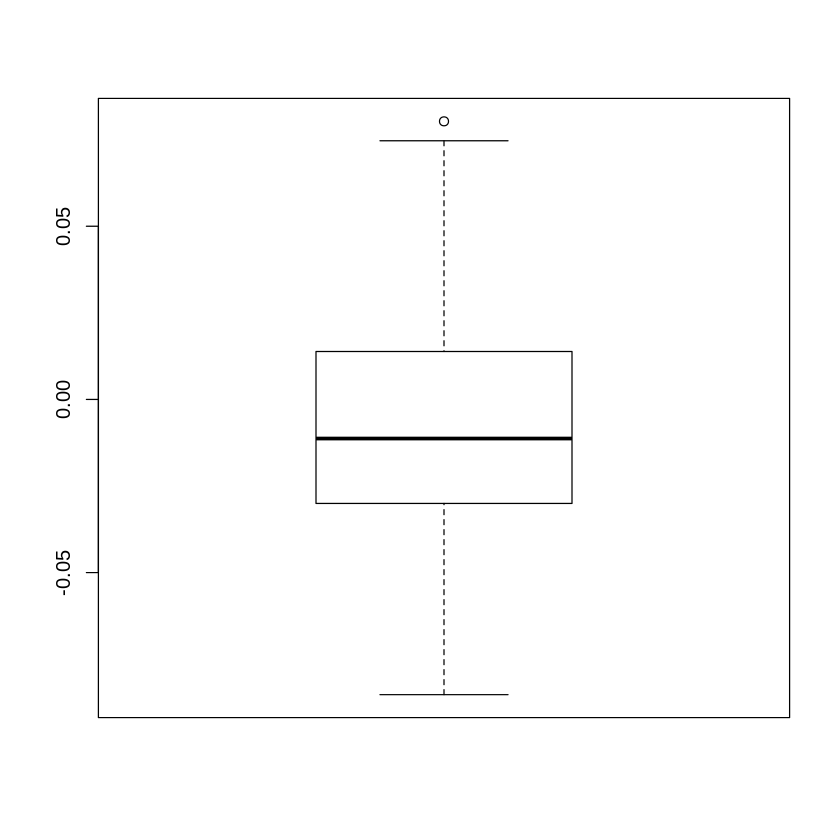

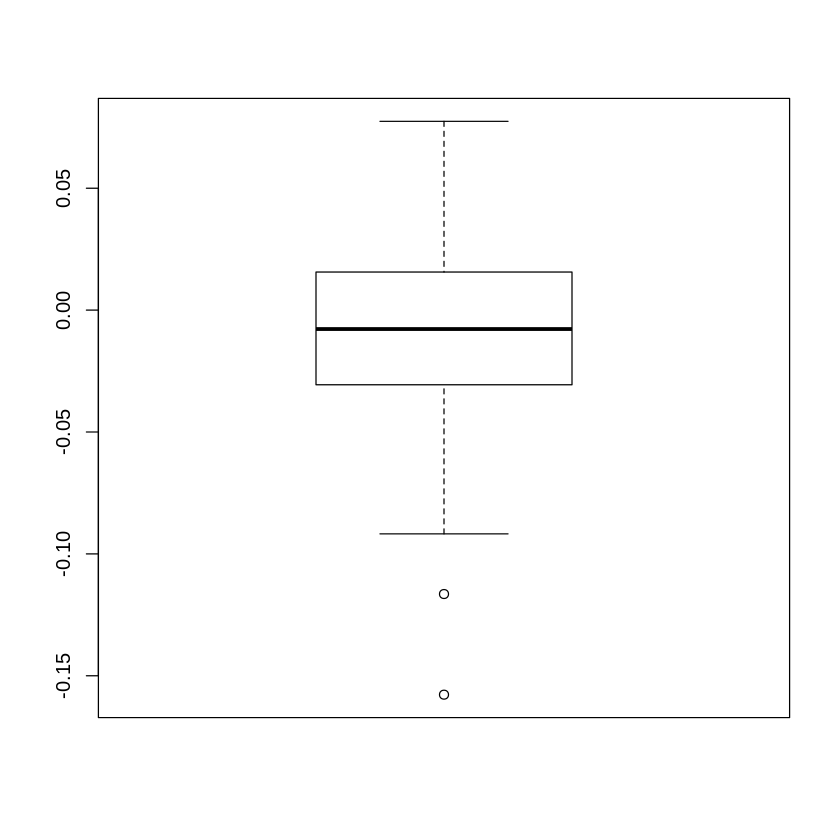

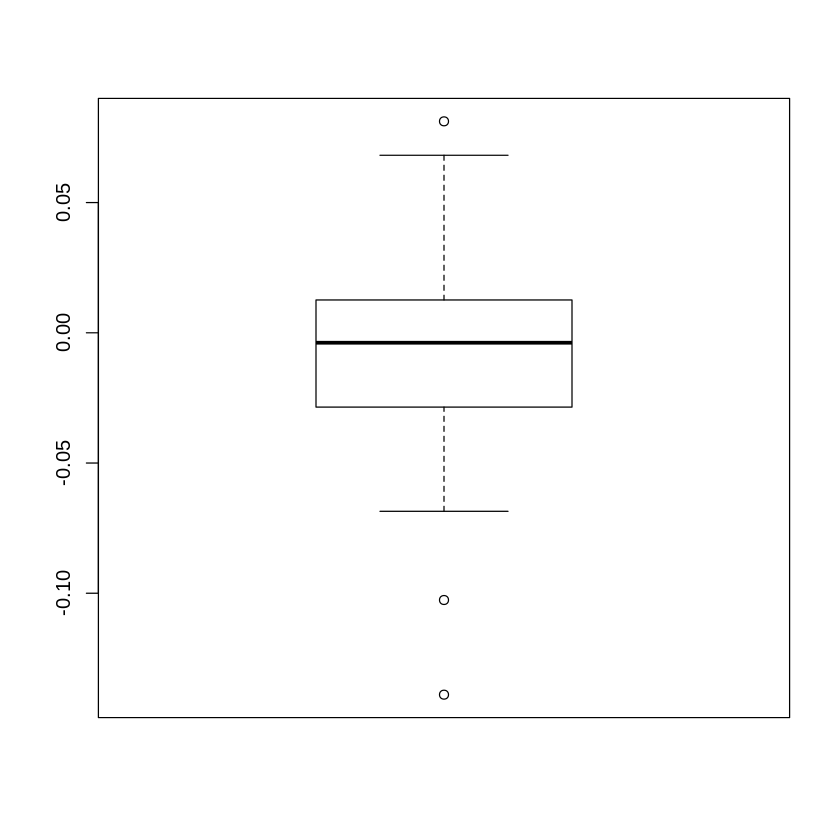

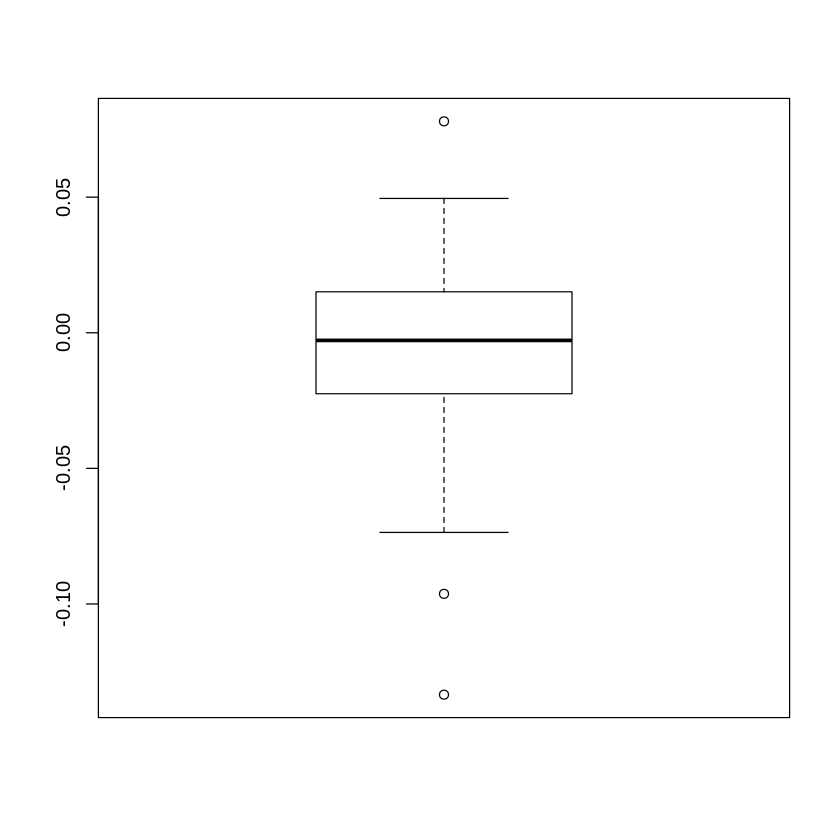

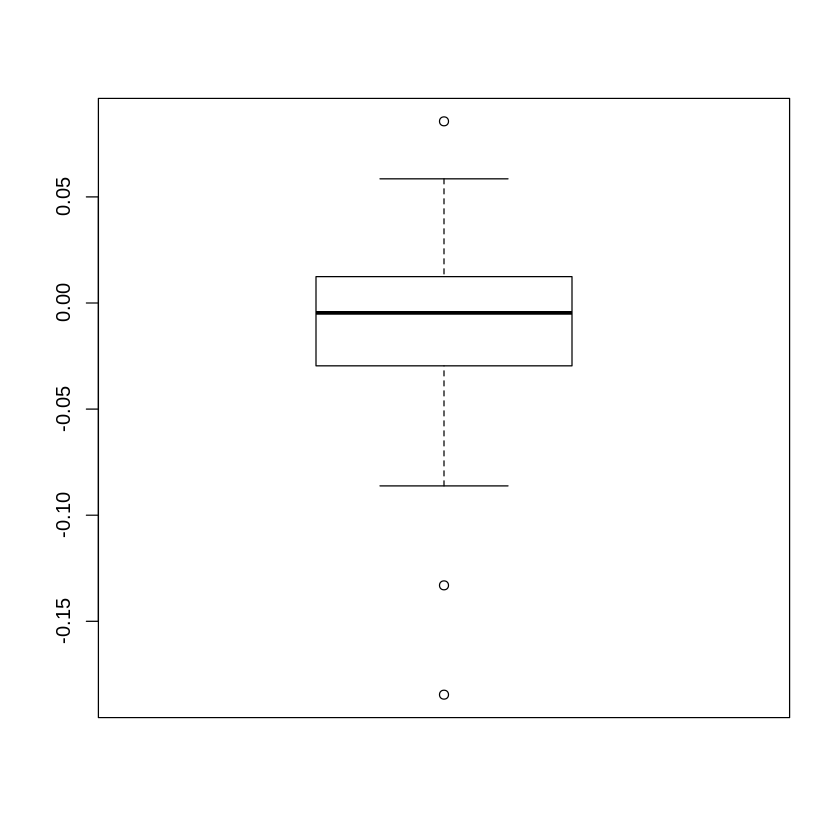

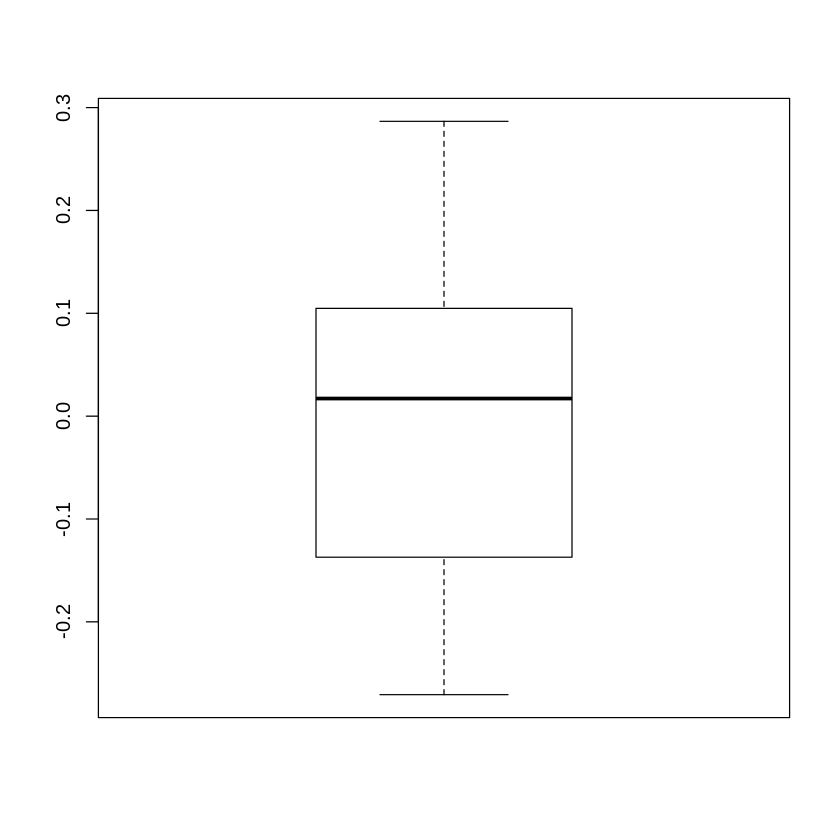

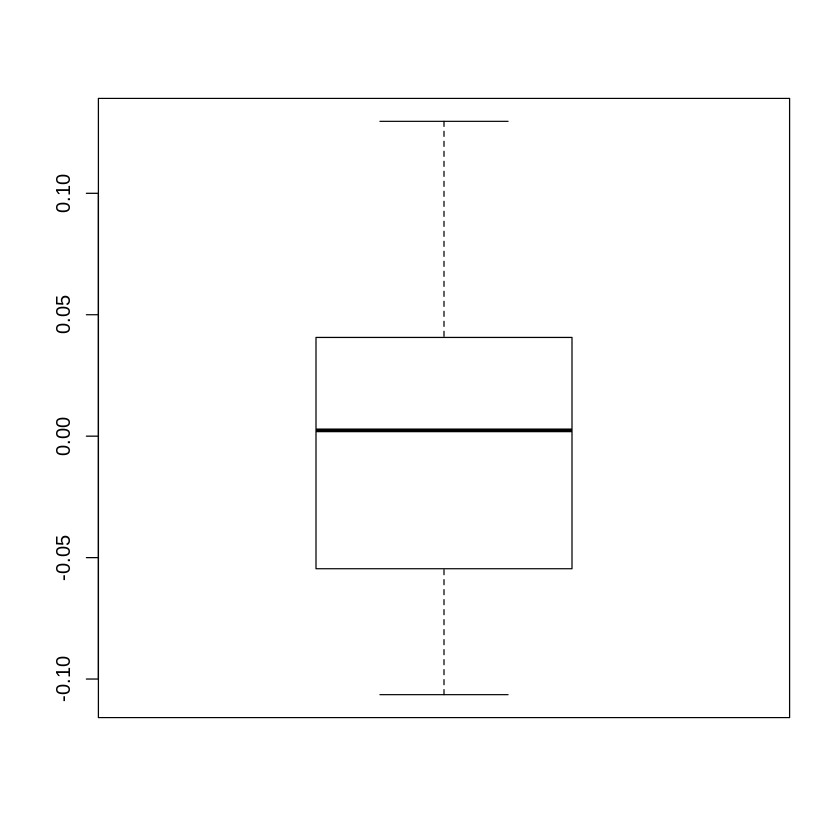

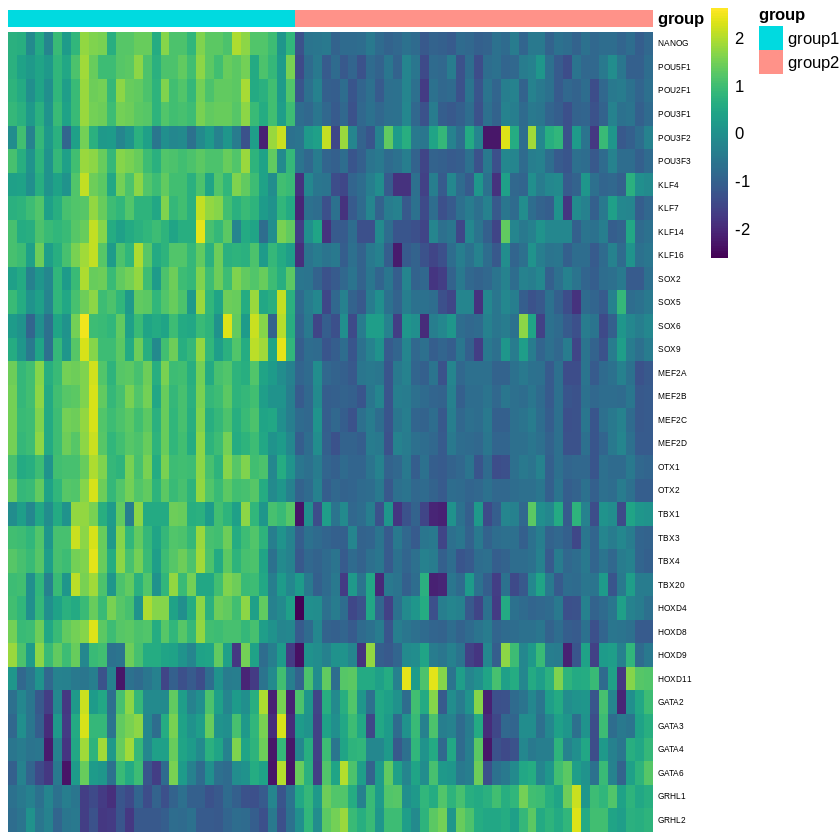

In [49]:
plot_deviation_heatmap(genelist)

In [ ]:
plot_gene_heatmap <- function(genelist) {
  dat <- rna.seurat[,c(grep("group1",colData(atac.dev.motifDB)$group),grep("group2",colData(atac.dev.motifDB)$group))]
  gene_id <- hsapiens.genes$gene_id[match(genelist,hsapiens.genes$gene_name,nomatch = 0)]
  dat <- dat[match(gene_id,rownames(dat),nomatch = 0),]
  rownames(dat) <- hsapiens.genes$gene_name[match(rownames(dat),hsapiens.genes$gene_id,nomatch = 0)]
  dat <- apply(dat, 1, function(tf) {
    tf.box <- boxplot(tf)
    out <- names(tf.box$out)
    tf[out] <- ifelse(tf[out] > 0, tf.box$stats[5,],tf.box$stats[1,])
    return(tf)
  })  
  label = data.frame(group = c(rep("group1",32),rep("group2",40)),
                     row.names = colnames(t(dat)))
  pheatmap(t(dat),
          scale = "row",
          cluster_cols = F,
          cluster_rows = F,
         show_rownames = T, 
         show_colnames = F,
         clustering_method = "ward.D2",
         fontsize_row = 5,
         color = magma(100),
         border_color = NA,
         annotation_col = label)
}

In [37]:
plot_gene_heatmap(genelist)

ERROR: Error in plot_gene_heatmap(genelist): object 'hsapiens.genes' not found


In [40]:
rna.seurat <- ScaleData(object = rna.seurat, vars.to.regress = "nCount_RNA")

Regressing out nCount_RNA
Centering and scaling data matrix


In [38]:
dat <- rna.seurat[,c(grep("group1",colData(atac.dev.motifDB)$group),grep("group2",colData(atac.dev.motifDB)$group))]

In [39]:
dat

An object of class Seurat 
24178 features across 70 samples within 1 assay 
Active assay: RNA (24178 features)